In [1]:
import scanpy as sc
import cell2cell as c2c
import liana as li

import numpy as np
import pandas as pd

import os

from tqdm.auto import tqdm

# Directories

In [2]:
data_folder = '../Data/'
directory = os.fsencode(data_folder)

In [3]:
output_folder = '../Data/LIANA-outputs/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# Data

In [4]:
adata = sc.read_h5ad(data_folder + 'BALF-COVID19-Liao_et_al-NatMed-2020.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

In [6]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control


# Short preprocessing

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

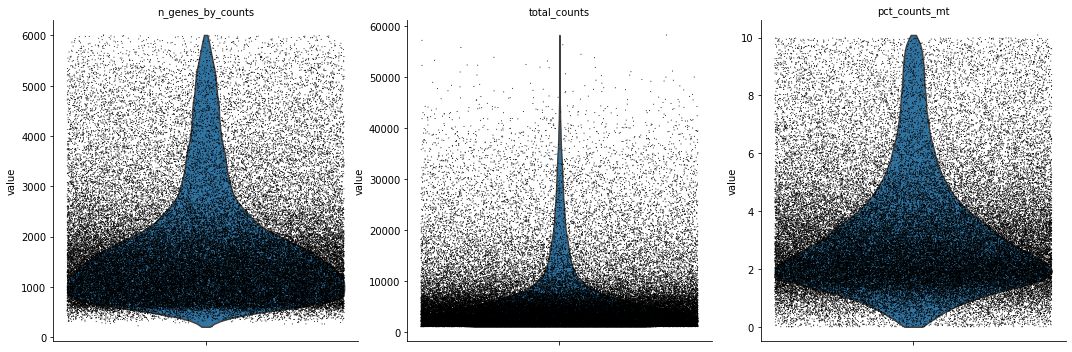

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

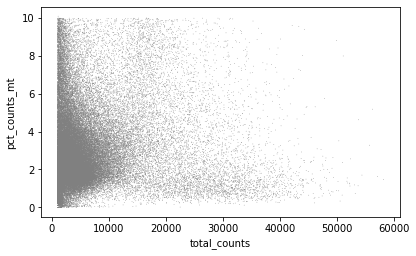

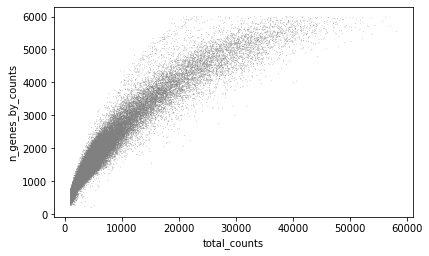

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [12]:
adata

View of AnnData object with n_obs × n_vars = 62552 × 24798
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
sc.pp.normalize_total(adata, target_sum=1e6)

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.


In [14]:
sc.pp.log1p(adata)

In [15]:
adata.raw = adata.copy()

# Run LIANA

In [16]:
for sample in tqdm(adata.obs['sample_new'].unique()):
    tmp_adata = adata[adata.obs['sample_new'] == sample]
    
    li.mt.rank_aggregate(tmp_adata, groupby='celltype', expr_prop=0.1, verbose=True)
    
    tmp_adata.uns['liana_res']['log_magnitude_rank'] = tmp_adata.uns['liana_res']['magnitude_rank'].apply(lambda x: -np.log(x+1e-9))
    tmp_adata.uns['liana_res'].to_csv(output_folder + sample + '.csv', index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

Using `.raw`!
5580 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


The following cell identities were excluded: Plasma
0.33 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2548 samples and 19218 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 61%|█████████████████████████████████████████████████████████████████                                          | 608/1000 [00:05<00:03, 114.08it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.26it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 10%|███████████▏                                                                                                | 104/1000 [00:07<01:03, 14.10it/s]


 21%|██████████████████████▋                                                                                     | 210/1000 [00:14<00:55, 14.27it/s]


 32%|██████████████████████████████████▏                                                                         | 316/1000 [00:22<00:50, 13.67it/s]


 42%|█████████████████████████████████████████████▌                                                              | 422/1000 [00:29<00:40, 14.22it/s]


 53%|█████████████████████████████████████████████████████████                                                   | 528/1000 [00:37<00:33, 14.23it/s]


 63%|████████████████████████████████████████████████████████████████████▍                                       | 634/1000 [00:45<00:25, 14.25it/s]


 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 740/1000 [00:52<00:18, 14.23it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 846/1000 [01:00<00:10, 14.16it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 952/1000 [01:07<00:03, 14.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.06it/s]
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


Using `.raw`!
8265 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast, Neutrophil, Plasma, pDC
0.39 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 348 samples and 16533 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.96it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 731/1000 [00:05<00:01, 139.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.13it/s]
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


Using `.raw`!
4236 features of mat are empty, they will be removed.
The following cell identities were excluded: Plasma
0.24 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2046 samples and 20562 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 868/1000 [00:05<00:00, 157.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.76it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 16%|████████████████▊                                                                                           | 156/1000 [00:06<00:36, 23.44it/s]


 32%|██████████████████████████████████                                                                          | 315/1000 [00:13<00:29, 23.44it/s]


 47%|███████████████████████████████████████████████████▏                                                        | 474/1000 [00:20<00:23, 22.66it/s]


 63%|████████████████████████████████████████████████████████████████████▎                                       | 633/1000 [00:27<00:15, 23.63it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 792/1000 [00:34<00:09, 22.99it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 951/1000 [00:40<00:02, 22.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.21it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
5703 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


The following cell identities were excluded: Plasma, pDC
0.33 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 8450 samples and 19095 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 50%|██████████████████████████████████████████████████████▍                                                     | 504/1000 [00:05<00:05, 91.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.21it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



  5%|█████▋                                                                                                       | 52/1000 [00:13<04:01,  3.93it/s]


 10%|███████████▎                                                                                                | 105/1000 [00:27<03:57,  3.77it/s]


 16%|█████████████████                                                                                           | 158/1000 [00:42<03:54,  3.59it/s]


 21%|██████████████████████▊                                                                                     | 211/1000 [00:57<03:34,  3.67it/s]


 26%|████████████████████████████▌                                                                               | 264/1000 [01:11<03:14,  3.79it/s]


 32%|██████████████████████████████████▏                                                                         | 317/1000 [01:25<02:57,  3.85it/s]


 37%|███████████████████████████████████████▉                                                                    | 370/1000 [01:39<02:43,  3.85it/s]


 42%|█████████████████████████████████████████████▋                                                              | 423/1000 [01:52<02:30,  3.85it/s]


 48%|███████████████████████████████████████████████████▍                                                        | 476/1000 [02:06<02:14,  3.88it/s]


 53%|█████████████████████████████████████████████████████████▏                                                  | 529/1000 [02:20<02:02,  3.86it/s]


 58%|██████████████████████████████████████████████████████████████▊                                             | 582/1000 [02:34<01:46,  3.91it/s]


 64%|████████████████████████████████████████████████████████████████████▌                                       | 635/1000 [02:47<01:35,  3.84it/s]


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 688/1000 [03:01<01:20,  3.90it/s]


 74%|████████████████████████████████████████████████████████████████████████████████                            | 741/1000 [03:15<01:05,  3.94it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 794/1000 [03:28<00:54,  3.76it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 847/1000 [03:42<00:39,  3.90it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 900/1000 [03:57<00:27,  3.67it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [04:11<00:13,  3.56it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:23<00:00,  3.79it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
3113 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


The following cell identities were excluded: Mast, Neutrophil
0.22 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 3376 samples and 21685 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 35%|██████████████████████████████████████▏                                                                     | 354/1000 [00:05<00:13, 49.53it/s]


 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 735/1000 [00:11<00:04, 62.42it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.46it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



  5%|█████▋                                                                                                       | 52/1000 [00:06<01:59,  7.93it/s]


 10%|███████████▎                                                                                                | 105/1000 [00:13<01:49,  8.15it/s]


 16%|█████████████████                                                                                           | 158/1000 [00:19<01:45,  7.99it/s]


 21%|██████████████████████▊                                                                                     | 211/1000 [00:26<01:45,  7.45it/s]


 26%|████████████████████████████▌                                                                               | 264/1000 [00:33<01:40,  7.30it/s]


 32%|██████████████████████████████████▏                                                                         | 317/1000 [00:40<01:22,  8.32it/s]


 37%|███████████████████████████████████████▉                                                                    | 370/1000 [00:47<01:17,  8.16it/s]


 42%|█████████████████████████████████████████████▋                                                              | 423/1000 [00:53<01:10,  8.19it/s]


 48%|███████████████████████████████████████████████████▍                                                        | 476/1000 [01:00<01:03,  8.31it/s]


 53%|█████████████████████████████████████████████████████████▏                                                  | 529/1000 [01:06<00:58,  8.12it/s]


 58%|██████████████████████████████████████████████████████████████▊                                             | 582/1000 [01:13<00:50,  8.24it/s]


 64%|████████████████████████████████████████████████████████████████████▌                                       | 635/1000 [01:19<00:47,  7.72it/s]


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 688/1000 [01:26<00:37,  8.23it/s]


 74%|████████████████████████████████████████████████████████████████████████████████                            | 741/1000 [01:32<00:33,  7.68it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 794/1000 [01:39<00:25,  7.97it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 847/1000 [01:46<00:19,  7.87it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 900/1000 [01:53<00:12,  7.90it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [01:59<00:05,  7.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.92it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
2524 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


0.20 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 11758 samples and 22274 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 16%|████████████████▊                                                                                           | 156/1000 [00:06<00:29, 28.37it/s]


 32%|██████████████████████████████████                                                                          | 315/1000 [00:11<00:32, 21.32it/s]


 47%|███████████████████████████████████████████████████                                                         | 473/1000 [00:19<00:26, 19.94it/s]


 63%|████████████████████████████████████████████████████████████████████▎                                       | 632/1000 [00:26<00:18, 20.33it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 791/1000 [00:33<00:09, 21.71it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 946/1000 [00:39<00:02, 26.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.76it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



  5%|█████▋                                                                                                       | 52/1000 [00:26<08:15,  1.91it/s]


 10%|███████████▎                                                                                                | 105/1000 [00:53<07:10,  2.08it/s]


 16%|█████████████████                                                                                           | 158/1000 [01:20<07:40,  1.83it/s]


 21%|██████████████████████▊                                                                                     | 211/1000 [01:48<06:53,  1.91it/s]


 26%|████████████████████████████▌                                                                               | 264/1000 [02:15<06:07,  2.00it/s]


 32%|██████████████████████████████████▏                                                                         | 317/1000 [02:41<05:36,  2.03it/s]


 37%|███████████████████████████████████████▉                                                                    | 370/1000 [03:07<05:19,  1.97it/s]


 42%|█████████████████████████████████████████████▋                                                              | 423/1000 [03:35<04:36,  2.09it/s]


 48%|███████████████████████████████████████████████████▍                                                        | 476/1000 [04:01<04:18,  2.03it/s]


 53%|█████████████████████████████████████████████████████████▏                                                  | 529/1000 [04:27<03:52,  2.03it/s]


 58%|██████████████████████████████████████████████████████████████▊                                             | 582/1000 [04:53<03:26,  2.02it/s]


 64%|████████████████████████████████████████████████████████████████████▌                                       | 635/1000 [05:19<02:54,  2.10it/s]


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 688/1000 [05:44<02:30,  2.08it/s]


 74%|████████████████████████████████████████████████████████████████████████████████                            | 741/1000 [06:09<02:08,  2.02it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 794/1000 [06:36<01:43,  1.98it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 847/1000 [07:02<01:15,  2.02it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 900/1000 [07:28<00:50,  1.99it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [07:54<00:24,  1.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:18<00:00,  2.00it/s]
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


Using `.raw`!
3430 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast, pDC
0.23 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2879 samples and 21368 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 940/1000 [00:05<00:00, 178.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.63it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 10%|███████████▏                                                                                                | 104/1000 [00:07<01:03, 14.15it/s]


 21%|██████████████████████▋                                                                                     | 210/1000 [00:14<00:54, 14.46it/s]


 32%|██████████████████████████████████▏                                                                         | 316/1000 [00:22<00:47, 14.38it/s]


 42%|█████████████████████████████████████████████▌                                                              | 422/1000 [00:29<00:40, 14.26it/s]


 53%|█████████████████████████████████████████████████████████                                                   | 528/1000 [00:37<00:33, 14.25it/s]


 63%|████████████████████████████████████████████████████████████████████▍                                       | 634/1000 [00:44<00:26, 14.05it/s]


 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 740/1000 [00:52<00:18, 14.37it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 846/1000 [00:59<00:11, 13.96it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 952/1000 [01:07<00:03, 13.59it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.07it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
1629 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


0.15 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 16854 samples and 23169 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 10%|███████████▏                                                                                                | 104/1000 [00:06<00:57, 15.68it/s]


 21%|██████████████████████▋                                                                                     | 210/1000 [00:13<00:51, 15.27it/s]


 32%|██████████████████████████████████▏                                                                         | 316/1000 [00:20<00:43, 15.58it/s]


 42%|█████████████████████████████████████████████▌                                                              | 422/1000 [00:27<00:36, 15.63it/s]


 53%|█████████████████████████████████████████████████████████                                                   | 528/1000 [00:34<00:30, 15.25it/s]


 63%|████████████████████████████████████████████████████████████████████▍                                       | 634/1000 [00:41<00:23, 15.64it/s]


 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 740/1000 [00:47<00:16, 15.63it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 846/1000 [00:54<00:10, 15.33it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 952/1000 [01:01<00:03, 15.75it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.41it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



  5%|█████▋                                                                                                       | 52/1000 [00:38<11:37,  1.36it/s]


 10%|███████████▎                                                                                                | 105/1000 [01:19<11:38,  1.28it/s]


 16%|█████████████████                                                                                           | 158/1000 [02:01<10:52,  1.29it/s]


 21%|██████████████████████▊                                                                                     | 211/1000 [02:41<10:01,  1.31it/s]


 26%|████████████████████████████▌                                                                               | 264/1000 [03:22<09:02,  1.36it/s]


 32%|██████████████████████████████████▏                                                                         | 317/1000 [04:02<08:42,  1.31it/s]


 37%|███████████████████████████████████████▉                                                                    | 370/1000 [04:44<08:32,  1.23it/s]


 42%|█████████████████████████████████████████████▋                                                              | 423/1000 [05:25<07:12,  1.33it/s]


 48%|███████████████████████████████████████████████████▍                                                        | 476/1000 [06:04<06:29,  1.35it/s]


 53%|█████████████████████████████████████████████████████████▏                                                  | 529/1000 [06:45<06:15,  1.26it/s]


 58%|██████████████████████████████████████████████████████████████▊                                             | 582/1000 [07:27<05:19,  1.31it/s]


 64%|████████████████████████████████████████████████████████████████████▌                                       | 635/1000 [08:08<04:57,  1.23it/s]


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 688/1000 [08:51<04:02,  1.29it/s]


 74%|████████████████████████████████████████████████████████████████████████████████                            | 741/1000 [09:37<03:24,  1.27it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 794/1000 [10:19<02:38,  1.30it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 847/1000 [11:00<01:54,  1.34it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 900/1000 [11:40<01:15,  1.32it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [12:20<00:34,  1.35it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:55<00:00,  1.29it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
3340 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


The following cell identities were excluded: Mast, Neutrophil, Plasma
0.21 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 3174 samples and 21458 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 51%|███████████████████████████████████████████████████████▌                                                    | 514/1000 [00:05<00:05, 91.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.49it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 10%|███████████                                                                                                 | 102/1000 [00:09<01:25, 10.56it/s]


 21%|██████████████████████▍                                                                                     | 208/1000 [00:19<01:13, 10.77it/s]


 31%|█████████████████████████████████▉                                                                          | 314/1000 [00:29<01:06, 10.35it/s]


 42%|█████████████████████████████████████████████▎                                                              | 420/1000 [00:39<00:55, 10.48it/s]


 53%|████████████████████████████████████████████████████████▊                                                   | 526/1000 [00:50<00:46, 10.19it/s]


 63%|████████████████████████████████████████████████████████████████████▎                                       | 632/1000 [01:00<00:34, 10.65it/s]


 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 738/1000 [01:10<00:24, 10.69it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 844/1000 [01:20<00:14, 10.43it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 947/1000 [01:30<00:05,  9.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.46it/s]
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


Using `.raw`!
4570 features of mat are empty, they will be removed.
The following cell identities were excluded: B, Plasma
0.28 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 1283 samples and 20228 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.38it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 26%|████████████████████████████                                                                                | 260/1000 [00:05<00:15, 47.47it/s]


 52%|████████████████████████████████████████████████████████▋                                                   | 525/1000 [00:11<00:09, 47.53it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 790/1000 [00:16<00:04, 47.18it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.16it/s]
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


Using `.raw`!
3769 features of mat are empty, they will be removed.
The following cell identities were excluded: B, pDC
0.21 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 1641 samples and 21029 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 801/1000 [00:05<00:01, 147.31it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.37it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



 16%|████████████████▋                                                                                           | 155/1000 [00:06<00:34, 24.31it/s]


 31%|█████████████████████████████████▉                                                                          | 314/1000 [00:12<00:28, 24.11it/s]


 47%|███████████████████████████████████████████████████                                                         | 473/1000 [00:19<00:20, 25.54it/s]


 63%|████████████████████████████████████████████████████████████████████▎                                       | 632/1000 [00:26<00:15, 23.60it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 791/1000 [00:32<00:08, 23.45it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 950/1000 [00:39<00:02, 23.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.94it/s]
Trying to set attribute `._uns` of view, copying.


Using `.raw`!
6725 features of mat are empty, they will be removed.


Trying to set attribute `.obs` of view, copying.


The following cell identities were excluded: NK, pDC
0.38 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 8149 samples and 18073 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



 63%|███████████████████████████████████████████████████████████████████▏                                       | 628/1000 [00:05<00:03, 115.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.15it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



  5%|█████▋                                                                                                       | 52/1000 [00:11<03:32,  4.45it/s]


 10%|███████████▎                                                                                                | 105/1000 [00:23<03:24,  4.38it/s]


 16%|█████████████████                                                                                           | 158/1000 [00:35<03:09,  4.45it/s]


 21%|██████████████████████▊                                                                                     | 211/1000 [00:47<03:04,  4.27it/s]


 26%|████████████████████████████▌                                                                               | 264/1000 [00:59<02:51,  4.28it/s]


 32%|██████████████████████████████████▏                                                                         | 317/1000 [01:11<02:35,  4.40it/s]


 37%|███████████████████████████████████████▉                                                                    | 370/1000 [01:24<02:41,  3.91it/s]


 42%|█████████████████████████████████████████████▋                                                              | 423/1000 [01:36<02:08,  4.50it/s]


 48%|███████████████████████████████████████████████████▍                                                        | 476/1000 [01:48<01:57,  4.48it/s]


 53%|█████████████████████████████████████████████████████████▏                                                  | 529/1000 [02:00<01:50,  4.25it/s]


 58%|██████████████████████████████████████████████████████████████▊                                             | 582/1000 [02:13<01:34,  4.43it/s]


 64%|████████████████████████████████████████████████████████████████████▌                                       | 635/1000 [02:25<01:19,  4.60it/s]


 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 688/1000 [02:37<01:11,  4.38it/s]


 74%|████████████████████████████████████████████████████████████████████████████████                            | 741/1000 [02:49<00:58,  4.46it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 794/1000 [03:00<00:44,  4.62it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 847/1000 [03:12<00:35,  4.32it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 900/1000 [03:24<00:22,  4.45it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 953/1000 [03:37<00:10,  4.34it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]
Trying to set attribute `._uns` of view, copying.
